In [1]:
import os
import re
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import config as conf
import pickle
import pandas as pd
import geopandas as gpd
import math
from od_connector import od_cnx
from shapely import wkt, geometry
from supernetwork import Supernetwork
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#%% read pickled supernetwork (which includes unimodal networks joined by transfer edges)
cwd = os.getcwd()
# G_super_od = od_cnx(os.path.join(cwd, 'Data', 'Output_Data', 'G_super.pkl'), 
#                         conf.config_data['Supernetwork']['org'],[-79.945482, 40.420469])

Read successful


<AxesSubplot: >

<AxesSubplot: >

28             Annotation(-79.9121, 40.4623, 'Larimer')
31           Annotation(-79.9323, 40.4535, 'Shadyside')
35        Annotation(-79.9246, 40.4647, 'East Liberty')
36     Annotation(-79.9547, 40.4386, 'Central Oakland')
37       Annotation(-79.9536, 40.4483, 'North Oakland')
44    Annotation(-79.9294, 40.4436, 'Squirrel Hill N...
50    Annotation(-79.9227, 40.4301, 'Squirrel Hill S...
53        Annotation(-79.9076, 40.4457, 'Point Breeze')
dtype: object

[]

[]

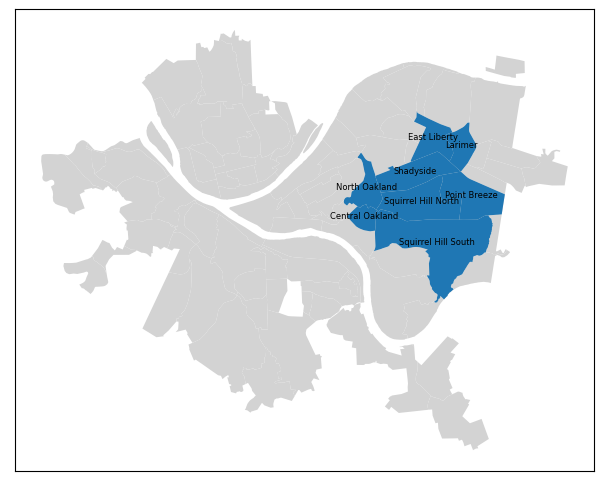

In [2]:
# choose only a single neighborhood to use for visualization
cwd = os.getcwd()
path = os.path.join(cwd, 'Data', 'Input_Data', 'Neighborhoods', "Neighborhoods_.shp")
nhoods_all = gpd.read_file(path)  # all neighborhoods
fig,ax = plt.subplots(figsize=(20,6))
# plot all the neighborhoods
nhoods_all.plot(ax=ax, color='lightgrey')
hood_list = conf.config_data['Geography']['neighborhoods']
hood_subset = nhoods_all.loc[nhoods_all['hood'].isin(hood_list)]
hood_subset.plot(ax=ax)
hood_subset.apply(lambda x: ax.annotate(text=x['hood'], xy=x.geometry.centroid.coords[0], 
                                        fontsize=6, ha='center'), axis=1)
# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])


In [3]:
streets_shapefile_path = os.path.join(cwd, 'Data', 'Input_Data', 'AlleghenyCounty_StreetCenterlines202208', 
                                     'AlleghenyCounty_StreetCenterlines202208.shp')
studyarea_filepath = os.path.join(cwd, 'Data', 'Output_Data', 'study_area.csv')
streets = gpd.read_file(streets_shapefile_path)
streets.to_crs('epsg:4326', inplace=True)
study_area_gdf = gpd.read_file(studyarea_filepath)
streets_clip = gpd.clip(streets, study_area_gdf).reset_index()

# clean the data: 
    # 1) remove pedestrian only ('A71', 'A72'), streams (H10), and alleys (A73)
    # 2) rename twoway streets from None to 'Both'
    # 3) record length of line
streets_clip = streets_clip[~streets_clip.FCC.isin(['A71', 'A72', 'A73', 'H10'])].reset_index(drop=True)
streets_clip['ONEWAY'].fillna(value='Both', inplace=True) 
#streets_clip['length_gcd'] = streets_clip['geometry'].apply(lambda x: calc_gcd_line(x))
streets_clip.to_crs(crs='epsg:32128', inplace=True)
streets_clip['length_meters'] = streets_clip.geometry.length

/home/lgraff/ENTER/envs/py39/lib/python3.9/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot: >

<AxesSubplot: >

28            Annotation(-79.9121, 40.4623, 'Larimer')
36    Annotation(-79.9547, 40.4386, 'Central Oakland')
dtype: object

<AxesSubplot: >

[]

[]

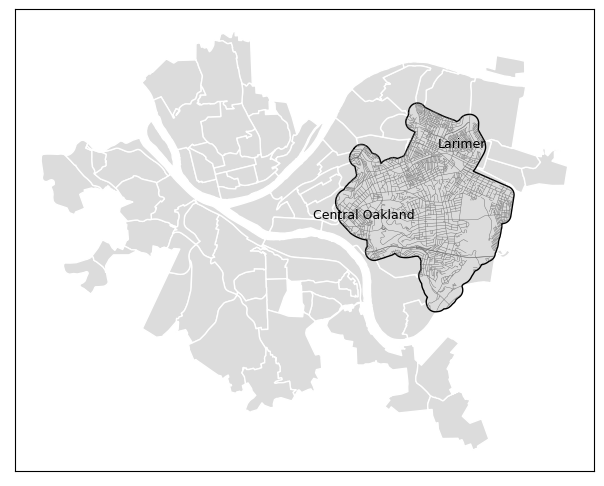

In [28]:
path = os.path.join(cwd, 'Data', 'Input_Data', 'Neighborhoods', "Neighborhoods_.shp")
nhoods_all = gpd.read_file(path)  # all neighborhoods
fig,ax = plt.subplots(figsize=(20,6))
nhoods_all.plot(ax=ax, color='gainsboro', edgecolor='white') # plot all the neighborhoods
hood_list = conf.config_data['Geography']['neighborhoods']
hood_subset = nhoods_all.loc[nhoods_all['hood'].isin(hood_list)]
#hood_subset.plot(ax=ax) # shade selected neighborhoods
study_area_gdf.plot(ax=ax, color='gainsboro',edgecolor='black')
# hood_subset.apply(lambda x: ax.annotate(text=x['hood'], xy=x.geometry.centroid.coords[0], 
#                                         fontsize=6, ha='center'), axis=1)
od_hoods = nhoods_all.loc[nhoods_all['hood'].isin(['Larimer','Central Oakland'])]
od_hoods.apply(lambda x: ax.annotate(text=x['hood'], xy=x.geometry.centroid.coords[0], 
                                        fontsize=9, ha='center'), axis=1)
streets_clip.to_crs(epsg='4326', inplace=True)
streets_clip.plot(ax=ax, color='dimgray', lw=0.3)
# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])



In [16]:
streets_clip.length_meters.sum()
streets_clip.Shape_Leng.sum()

397219.3009057378

1394488.337007104

In [131]:
# streets, bus stops, bike station, bike lane, zip car, parking meter

# Streets
streets_clip = gpd.clip(streets, study_area_gdf).reset_index()

# Bus stops
GTFS_filepath = os.path.join(cwd, 'Data', 'Input_Data', 'GTFS')
stops_df = pd.read_csv(os.path.join(GTFS_filepath, 'stops.txt'))
stops_gdf = gpd.GeoDataFrame(stops_df, geometry=gpd.points_from_xy(x=stops_df['stop_lon'], y=stops_df['stop_lat']), crs='EPSG:4326')
stops_clip = gpd.clip(stops_gdf, study_area_gdf).reset_index()

# Bikeshare
bs_filepath = os.path.join(cwd, 'Data', 'Input_Data', 'pogoh-station-locations-2022.csv')
df_bs = pd.read_csv(bs_filepath)
long_colname, lat_colname = 'Longitude', 'Latitude'
df_bs['geometry'] = gpd.points_from_xy(df_bs[long_colname], df_bs[lat_colname], crs="EPSG:4326")
gdf_bs = gpd.GeoDataFrame(df_bs)  # convert to geo df
bikeshare_clip = gpd.clip(gdf_bs, study_area_gdf).reset_index()

# Bike Lane 
bikemap_folder = os.path.join(cwd, 'Data', 'Input_Data', 'bike-map-2019')
# the WPRDC website provides different GIS files for each bikeway types. here we will concatenate them into one gdf 
# note: we will add trails separately because they are off-road and not included in street centerline file
bikeway_type = ['Bike Lanes', 'On Street Bike Route', 'Protected Bike Lane',
                'Bridges', 'Bikeable_Sidewalks', 'Cautionary Bike Route']
gdf_bikeway = gpd.GeoDataFrame()
for b in bikeway_type:
    new_path = os.path.join(bikemap_folder, b)
    filename = b + '.shp'
    gdf =  gpd.read_file(os.path.join(new_path, filename))
    gdf['bikeway_type'] = b
    cols_keep = ['geometry','bikeway_type']
    gdf = gdf[cols_keep]
    gdf_bikeway = pd.concat([gdf_bikeway, gdf])
# clip to the study area (need to change crs)
gdf_bikeway.to_crs(crs=4326, inplace=True) 
gdf_bikeway = gpd.clip(gdf_bikeway, study_area_gdf)
bikelane_keep = ['Bike Lanes', 'Protected Bike Lane', 'Bikeable_Sidewalks']
gdf_bikeway = gdf_bikeway[gdf_bikeway.bikeway_type.isin(bikelane_keep)]

# Parking meters
parking_filepath = os.path.join(cwd, 'Data', 'Input_Data','ParkingMetersPaymentPoints.csv')
df_park = pd.read_csv(parking_filepath)
# Remove rows that do not have both a lat and long populated
df_park = df_park.loc[~((df_park['latitude'].isnull()) | (df_park['longitude'].isnull()))]
df_park.loc[df_park.rate == 'Multi_Rate']
# Remove rows that do not have a rate populated or has a "Multi-Rate"
df_park = df_park.loc[(~(df_park['rate'].isnull()) & ~(df_park['rate'] == 'Multi-Rate'))]
gdf_park = gpd.GeoDataFrame(data=df_park, geometry=gpd.points_from_xy(x=df_park.longitude, y=df_park.latitude),crs='epsg:4326')
gdf_park_clip = gpd.clip(gdf_park, study_area_gdf)

# Car share station
zip_path = os.path.join(cwd,'Data','Input_Data','Zipcar_Depot.csv')
df_zip = pd.read_csv(zip_path)
gdf_zip = gpd.GeoDataFrame(data=df_zip, geometry=df_zip['WKT'].apply(wkt.loads), crs='EPSG:4326').reset_index()[['index','geometry']]
gdf_zip_clip = gpd.clip(gdf_zip, study_area_gdf)

/home/lgraff/ENTER/envs/py39/lib/python3.9/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


,id,location,location_type,latitude,longitude,status,zone,all_groups,guid,in_service_utc,rate,max_hours,hours,restrictions,special_events,rate_as_of


In [129]:
len(gdf_park_clip)

391

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

[]

[]

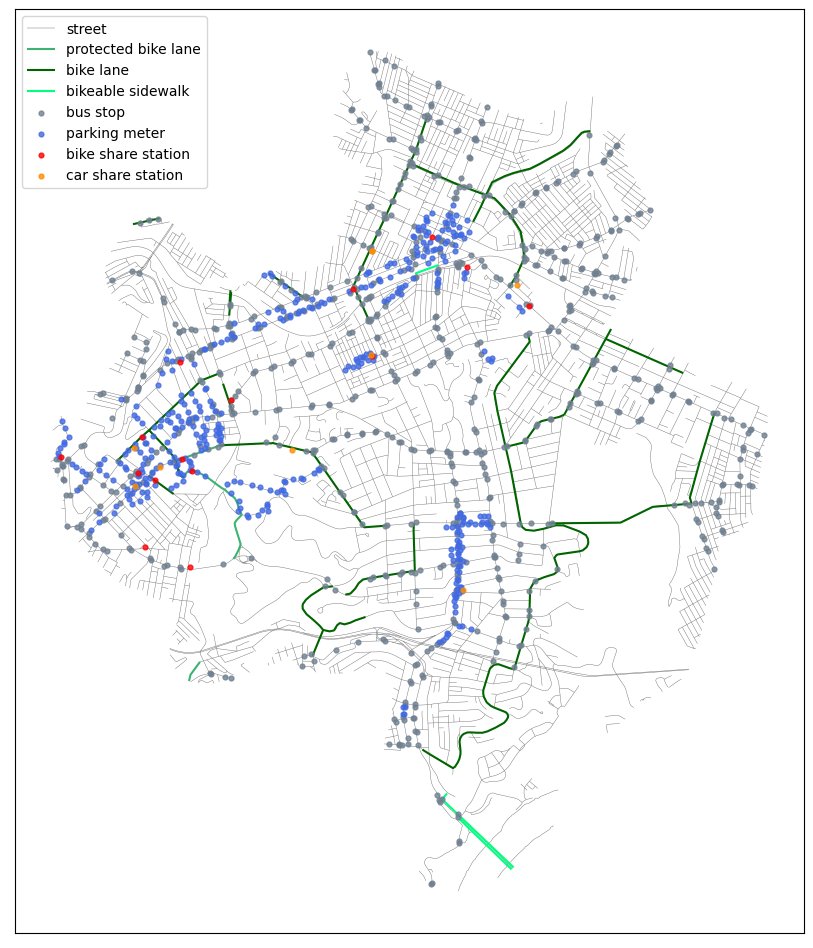

In [132]:
msize = 12
alpha = 0.8
fig,ax = plt.subplots(figsize=(20,12))
streets_clip.plot(ax=ax, color='dimgray', lw=0.3, zorder=0, label='street')
bikeway_cmap = {'Bike Lanes':'darkgreen','Protected Bike Lane':'mediumseagreen', 'Bikeable_Sidewalks':'springgreen'}
gdf_bikeway['color'] = gdf_bikeway['bikeway_type'].map(bikeway_cmap)
bikeway_namemap = {'Bike Lanes': 'bike lane', 'Protected Bike Lane':'protected bike lane', 'Bikeable_Sidewalks':'bikeable sidewalk'}
gdf_bikeway['bikeway_type'] = gdf_bikeway['bikeway_type'].map(bikeway_namemap)
for b in gdf_bikeway['bikeway_type'].unique():
    gdf_bikeway[gdf_bikeway['bikeway_type']==b].plot(ax=ax, color=gdf_bikeway[gdf_bikeway['bikeway_type']==b]['color'], zorder=1, label=b)
stops_clip.plot(ax=ax, color='slategray', alpha=alpha, markersize=msize, zorder=2, label='bus stop')
gdf_park_clip.plot(ax=ax, color='royalblue', alpha=alpha, markersize=msize, zorder=2, label='parking meter')
bikeshare_clip.plot(ax=ax, color='red', alpha=alpha, markersize=msize, zorder=2, label='bike share station')
gdf_zip_clip.plot(ax=ax, color='darkorange', alpha=alpha, markersize=msize, zorder=2, label='car share station')
#ax.legend()
# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])
ax.legend()

In [ ]:
hood = conf.config_data['Geography']['neighborhoods'][0]  # only the ith neighborhood in the list
hood_gdf = nhoods_all[nhoods_all['hood'] == hood]  

<AxesSubplot:>

<AxesSubplot:>

,index,pos,nwk_type,node_type,Station Name,# of Racks,Latitude,Longitude,geometry,zone,...,longitude,float_rate,stop_name,route_id,direction_id,stop_id,stop_sequence,x,y,nwk_name
0,bs0,"(-79.91422624760675, 40.42690024412817)",bs,bs,NaN,NaN,NaN,NaN,POINT (-79.91423 40.42690),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.914226,40.426900,NaN
1,bs1,"(-79.9497447003733, 40.43444259643129)",bs,bs,NaN,NaN,NaN,NaN,POINT (-79.94974 40.43444),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.949745,40.434443,NaN
2,bs2,"(-79.94241028344199, 40.41576232100757)",bs,bs,NaN,NaN,NaN,NaN,POINT (-79.94241 40.41576),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.942410,40.415762,NaN
3,bs3,"(-79.93749991958343, 40.432736188582965)",bs,bs,NaN,NaN,NaN,NaN,POINT (-79.93750 40.43274),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.937500,40.432736,NaN
4,bs4,"(-79.93615858988125, 40.43985819780361)",bs,bs,NaN,NaN,NaN,NaN,POINT (-79.93616 40.43986),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.936159,40.439858,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8036,tw216,"(-79.93178300536127, 40.44915345427908)",NaN,tw,NaN,NaN,NaN,NaN,POINT (-79.93178 40.44915),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.931783,40.449153,t
8037,tw937,"(-79.9255076896622, 40.45131091524447)",NaN,tw,NaN,NaN,NaN,NaN,POINT (-79.92551 40.45131),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.925508,40.451311,t
8038,tw508,"(-79.92843663059188, 40.45021164768596)",NaN,tw,NaN,NaN,NaN,NaN,POINT (-79.92844 40.45021),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.928437,40.450212,t
8039,org,"(-79.94868171046522, 40.416379503934145)",od,od,NaN,NaN,NaN,NaN,POINT (-79.94868 40.41638),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.948682,40.416380,NaN


c:\Users\lgraff\anaconda3\envs\mm\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\lgraff\anaconda3\envs\mm\lib\site-packages\pandas\core\dtypes\cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


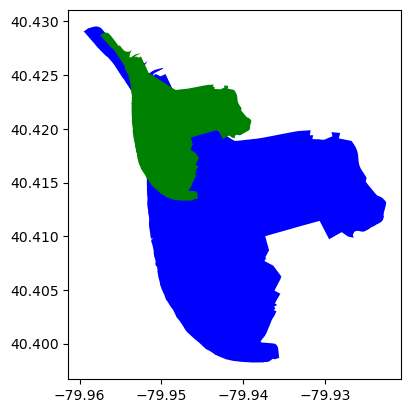

In [107]:


# one neighbrhood is still too big to visualize. let's scale down by 50%
fig,ax = plt.subplots()
scale_factor = 0.5
x=0.5
y=0.5
scaled_gdf = hood_gdf.geometry.scale(xfact=scale_factor, yfact=scale_factor).translate(-1/69*x, 1/69*y)
hood_gdf.plot(ax=ax, color='blue')
scaled_gdf.plot(ax=ax, color='green')
                           

df = pd.DataFrame.from_dict(dict(G_super_od.graph.nodes), orient="index").reset_index()
#gdf_pt = gpd.GeoDataFrame(data=df, geometry=df.pos)
df[['x','y']] = pd.DataFrame(df.pos.tolist())
gdf_nodes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x,df.y))
gdf_nodes.set_crs(epsg='4326', inplace=True)
nodes_clip = gpd.clip(gdf_nodes, scaled_gdf)
nodes_clip.set_index('index', inplace=True)

# go back to the original PT graph, only keep nodes edges that are within the selected neighborhood
# 1) Nodes
G = nx.DiGraph()
node_dict = nodes_clip.to_dict(orient='index')
G.add_nodes_from(node_dict.keys())
nx.set_node_attributes(G, node_dict)
# 2) Edges
df_edges = nx.to_pandas_edgelist(G_super_od.graph)
df_edges_keep = df_edges.loc[(df_edges['source'].isin(list(G.nodes))) & (df_edges['target'].isin(list(G.nodes)))]
df_edges_keep.set_index(['source','target'], inplace=True)
edge_dict = df_edges_keep.to_dict(orient='index')
G.add_edges_from(edge_dict.keys())
nx.set_edge_attributes(G, edge_dict)


In [114]:
#%% **for visualization**: jitter the graphs and draw
def jitter_nodes(G, network_type, jitter_param):
    #G_adj = G.copy()
    #print(G.nodes) #[node]['pos'])
    # adjust the nodes positions in the copy 

    # TODO: go back to original code that builds t-wait nodes. for the node attribute, change 'nwk_name' to 'nwd_type'
    nodes = [n for n in G.nodes.keys() if n not in ['org','dst'] if (G.nodes[n]['nwk_type'] == network_type or G.nodes[n]['nwk_name'] == network_type) ]
    for n in nodes:
        adj_x = G.nodes[n]['pos'][0] + jitter_param
        adj_y = G.nodes[n]['pos'][1] + jitter_param
        nx.set_node_attributes(G, {n: {'pos_adj':(adj_x, adj_y)}})

modes_included = conf.config_data['Supernetwork']['modes_included']
modes_included.remove('pt')
modes_included.insert(math.floor(len(modes_included)/2), 'pt')  # explicitly have PT graph be the one in the center

jitter_param_dict = {m: (j/200)*2 for j,m in enumerate(modes_included)}  # can adjust jitter param as necessary
jitter_param_dict['tw'] = jitter_param_dict['t']  # also include the tnc waiting nodes
# explicitly adjust org and dest if they are in the node list
if 'org' in list(G.nodes):
    G.nodes['org']['pos_adj'] = (G.nodes['org']['pos'][0], G.nodes['org']['pos'][1] + jitter_param_dict['sc']) 
if 'dst' in list(G.nodes):
    G.nodes['dst']['pos_adj'] = (G.nodes['dst']['pos'][0], G.nodes['dst']['pos'][1] + jitter_param_dict['sc']) 

for m in modes_included: #+ ['tw']:
    jitter_nodes(G, m, jitter_param_dict[m])

In [115]:
for n in G.nodes:
    if n.startswith('bsd'):
        print(n)

bsd1085


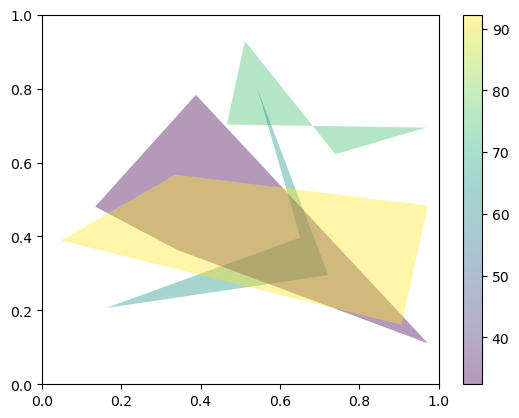

In [122]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Fixing random state for reproducibility
np.random.seed(19680801)

fig, ax = plt.subplots()

resolution = 50  # the number of vertices
N = 4
x = np.random.rand(N)
y = np.random.rand(N)
radii = 0.1*np.random.rand(N)
patches = []

for i in range(N):
    polygon = Polygon(np.random.rand(N, 2), closed=True)
    patches.append(polygon)

colors = 100 * np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.4)
p.set_array(colors)
ax.add_collection(p)
fig.colorbar(p, ax=ax)

plt.show()

In [116]:
# draw the graph in networkx
node_color_map = {'bs':'green', 'bsd':'lime', 'z':'blue', 'zd': 'skyblue', 'kz': 'dodgerblue',
                  'sc':'darkviolet', 't':'red', 'tw':'red', 'ps':'brown', 'rt': 'orange' , 'od':'black'}
node_color = [node_color_map[G.nodes[n]['node_type']] for n in G.nodes.keys()]
edges_remove = [e for e in G.edges if e[0].startswith('tw')]
edges_keep = list(set(list(G.edges)) - set(edges_remove))  # remove the edges that go from t-wait to t
edge_color = ['darkgray' if G.edges[e]['mode_type'] == 'w' else 'black' for e in edges_keep] 
edge_style = [(0,(5,10)) if G.edges[e]['mode_type'] == 'w' 
               else 'dotted' if G.edges[e]['mode_type'] in ['board','alight'] else 'solid' for e in edges_keep] 

pos = 'pos_adj'
node_coords = nx.get_node_attributes(G, pos)    

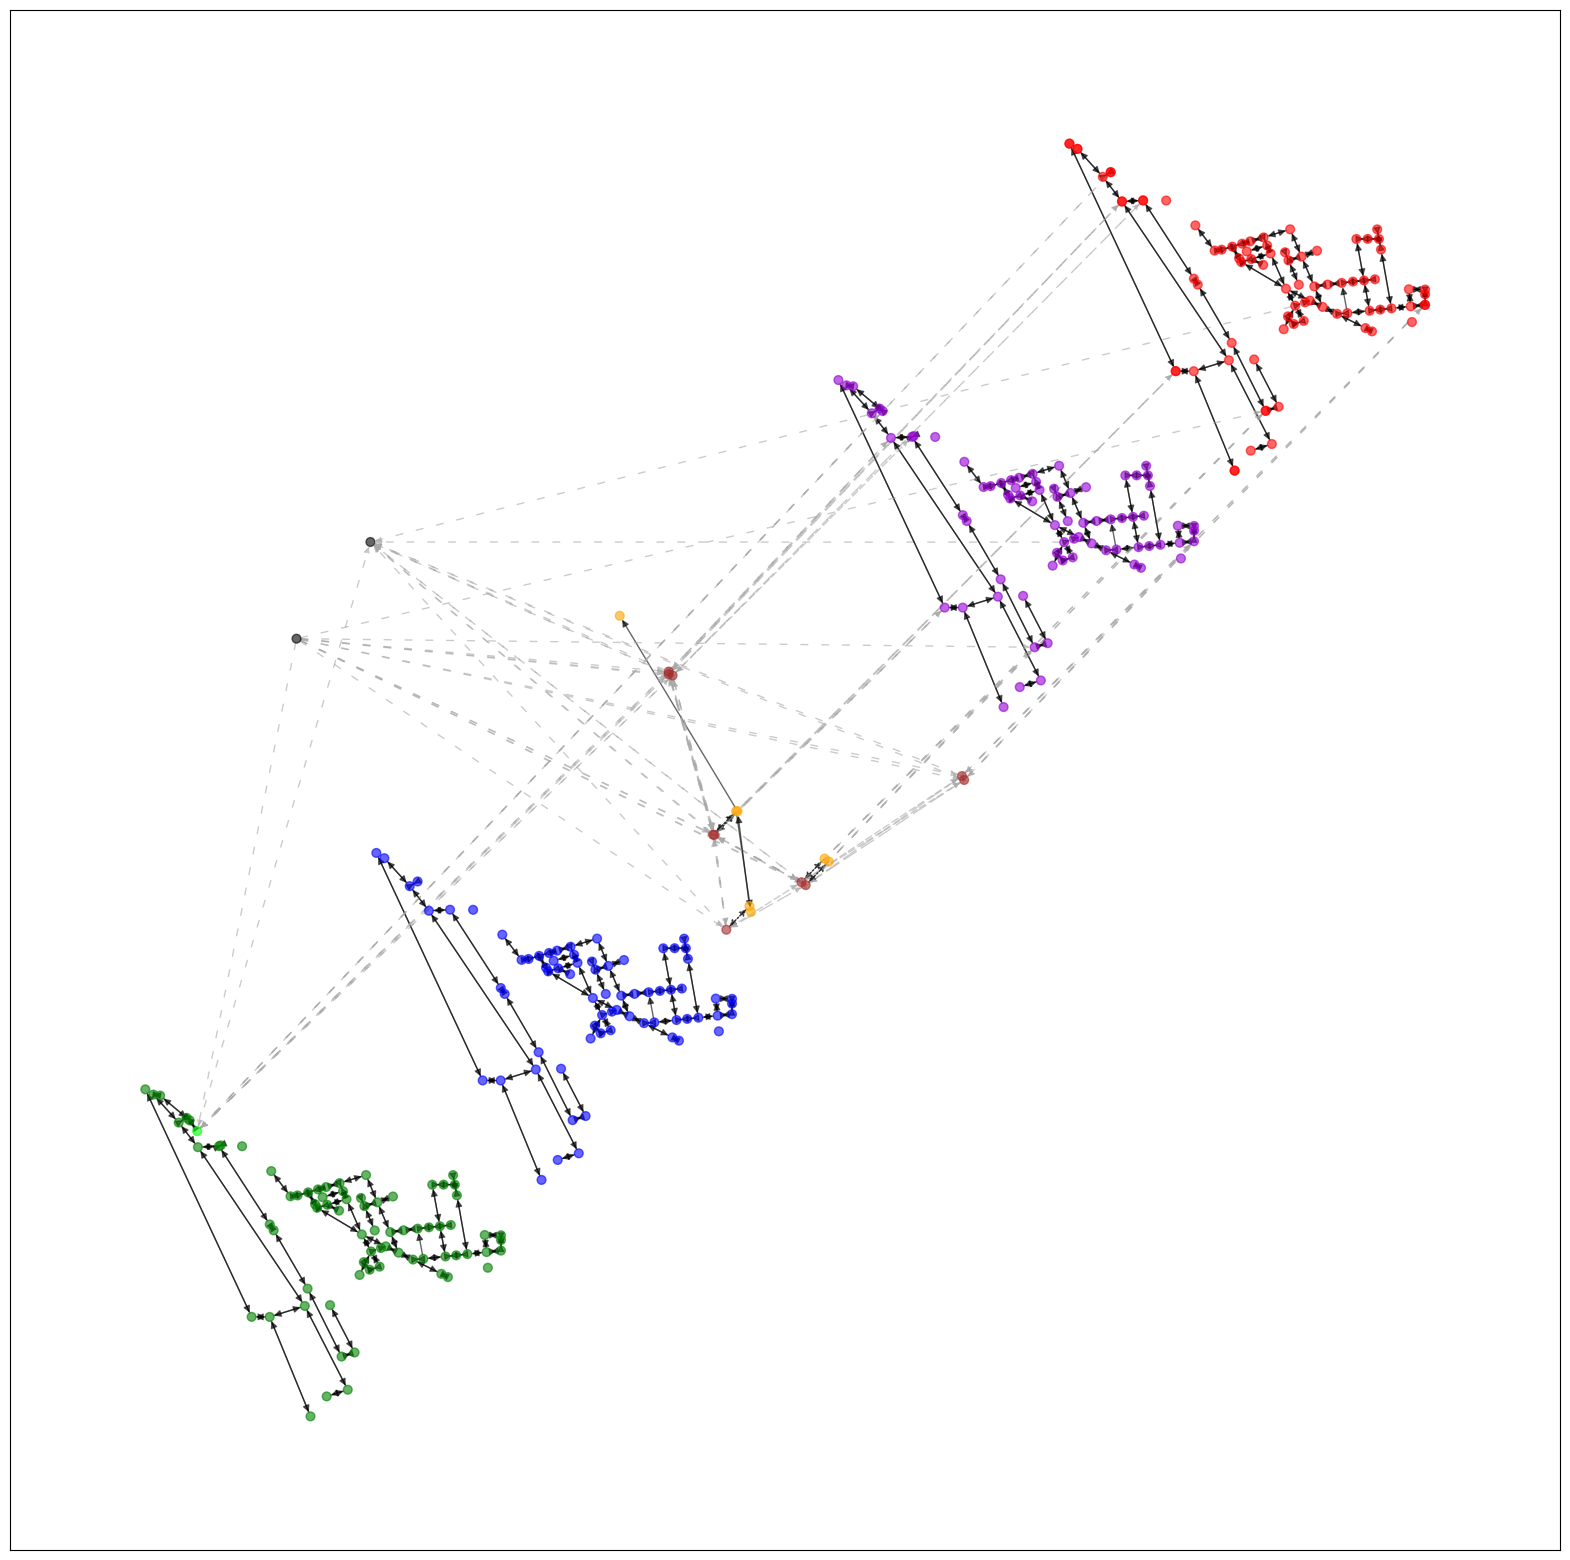

In [117]:
fig, ax = plt.subplots(figsize=(20,20))
nx.draw_networkx(G, pos=node_coords, node_color=node_color, node_size=40, alpha=0.6, edgelist=edges_keep, edge_color=edge_color, 
                style=edge_style, with_labels=False, ax=ax)

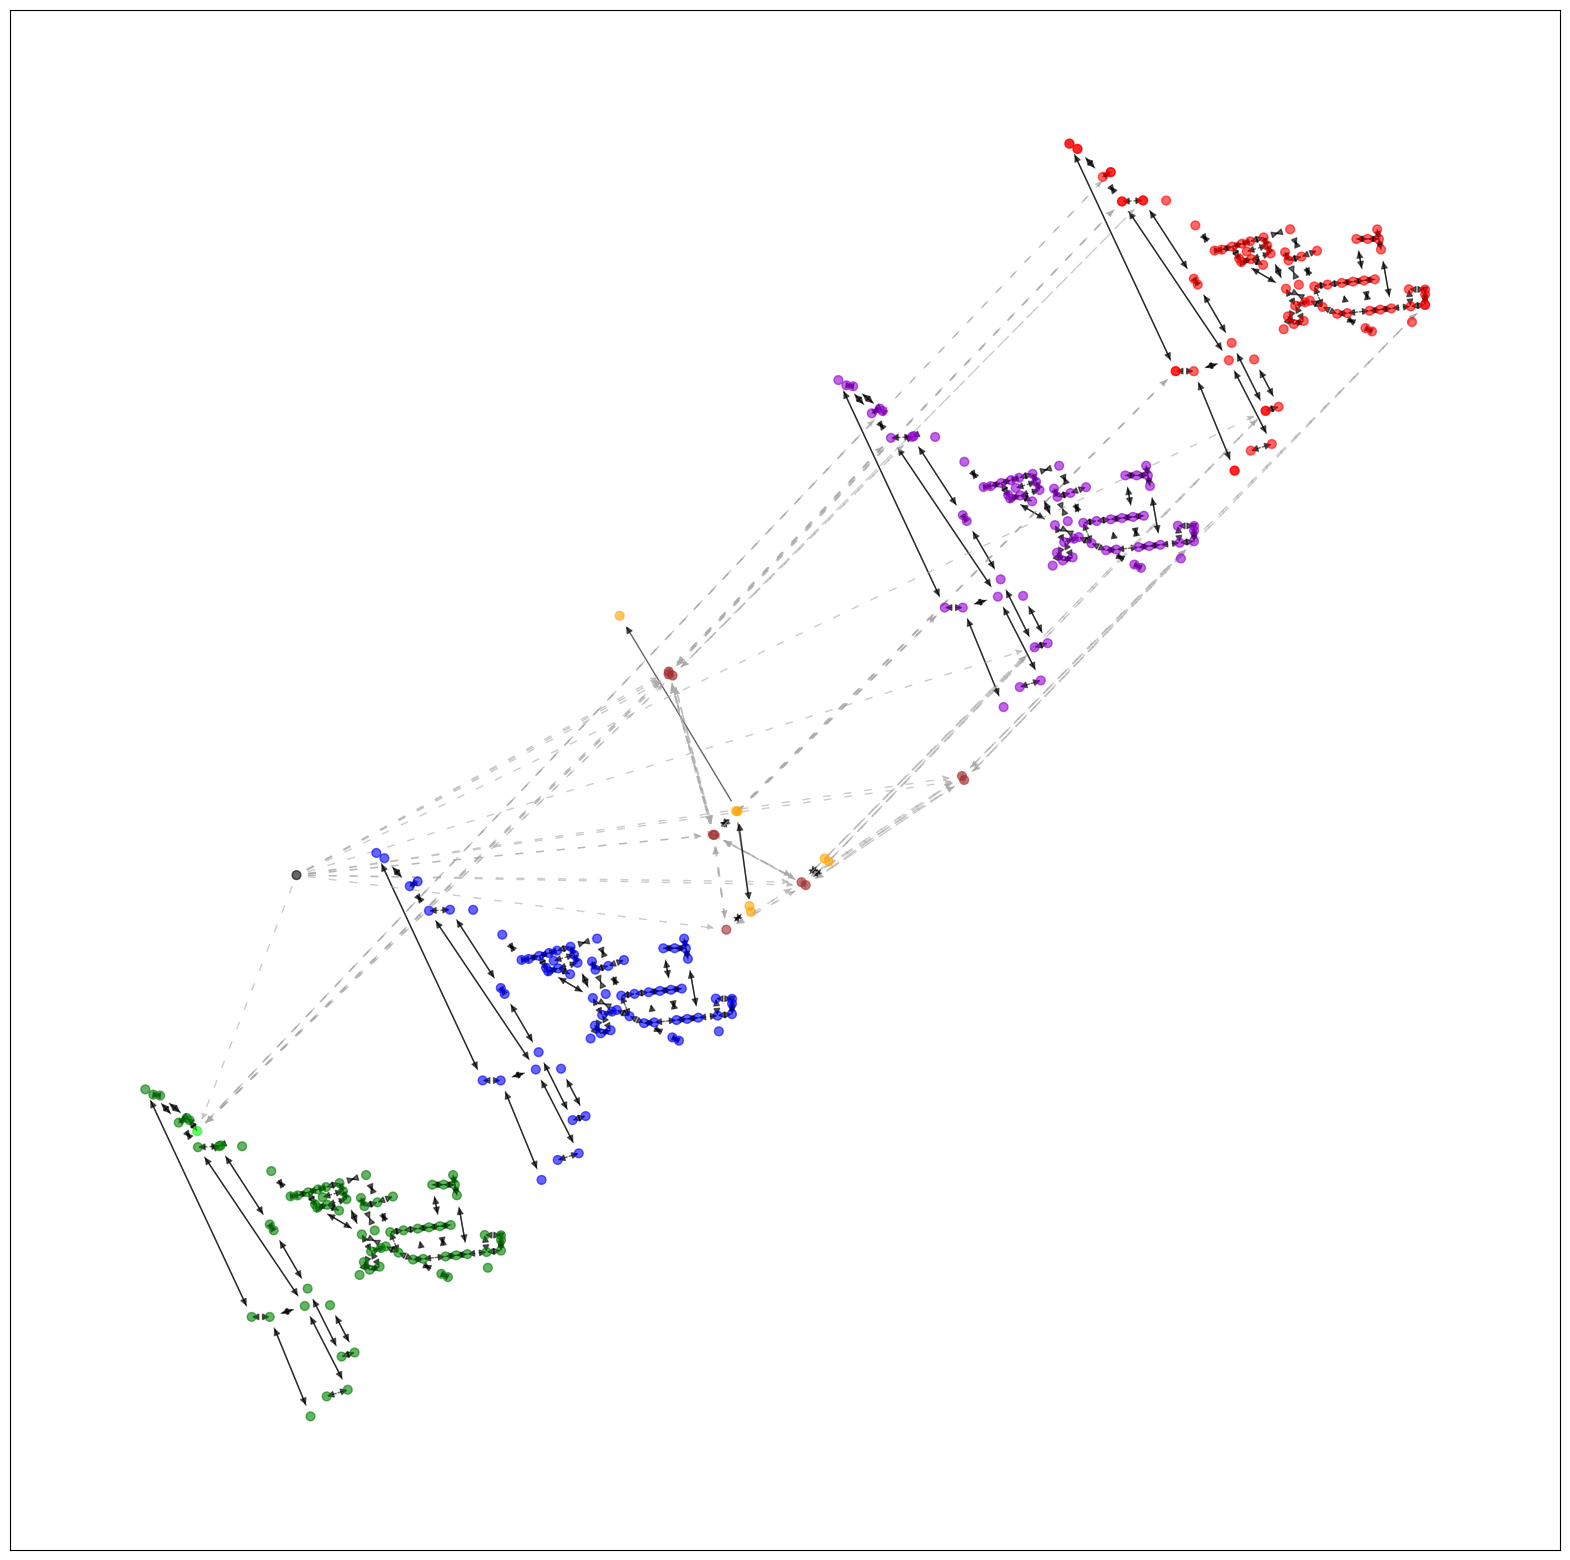

In [100]:
fig, ax = plt.subplots(figsize=(20,20))
nx.draw_networkx_nodes(G, pos=node_coords, node_color=node_color, node_size=40, alpha=0.6, ax=ax)
nx.draw_networkx_edges(G, pos=node_coords, edgelist=edges_keep, edge_color=edge_color, style=edge_style, alpha=0.6, arrowsize=10, ax=ax)